# Imports

In [1]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os

train_set_dir = '../data/train'
test_set_dir = '../data/test'
val_set_dir = '../data/val'

# Chargement du jeu de données

In [2]:
def open_images(data_generator, dataset_dir, batch_size):
    data_gen = data_generator.flow_from_directory(
    directory = dataset_dir,
    target_size = (250, 250),
    color_mode = 'grayscale',
    class_mode = 'binary',
    batch_size = batch_size)
    return data_gen

In [3]:
generator = tf.keras.preprocessing.image.ImageDataGenerator()

train_data_gen = open_images(generator, '../data/train', 1000)
test_data_gen = open_images(generator, '../data/test', 312)
val_data_gen = open_images(generator, '../data/val', 16)

target_names = ["Normal", "Pneumonia"]

Found 5206 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Normalisation du jeu de données

In [4]:
train_images, train_targets = next(train_data_gen)
test_images, test_targets = next(test_data_gen)
val_images, val_targets = next(val_data_gen)

print('Moyenne avant normalisation des données: ', train_images.mean())
print('Écart-type avant normalisation des données: ', train_images.std())
print()

train_images = train_images.reshape(-1, 62500)
test_images = test_images.reshape(-1, 62500)
val_images = val_images.reshape(-1, 62500)

scaler = StandardScaler()

train_images = train_images.astype(float)
train_images = scaler.fit_transform(train_images)
test_images = test_images.astype(float)
test_images = scaler.fit_transform(test_images)
val_images = val_images.astype(float)
val_images = scaler.fit_transform(val_images)

print('Moyenne après normalisation des données: ', train_images.mean())
print('Écart-type après normalisation des données: ', train_images.std())
print()

print(train_images.shape, train_targets.shape)
print(test_images.shape, test_targets.shape)
print(val_images.shape, val_targets.shape)

Moyenne avant normalisation des données:  122.595245
Écart-type avant normalisation des données:  60.66705

Moyenne après normalisation des données:  2.6092493499163538e-17
Écart-type après normalisation des données:  0.9999999999999998

(1000, 62500) (1000,)
(312, 62500) (312,)
(16, 62500) (16,)


## Affichage d'une image

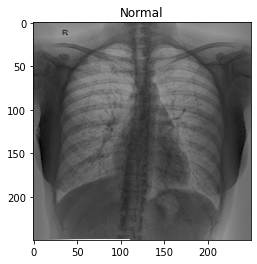

In [5]:
# Plot one image
plt.imshow(train_images[13].reshape(250, 250), cmap="binary")
plt.title(target_names[int(train_targets[13])])
plt.show()

## Affichage aléatoire de plusieurs images

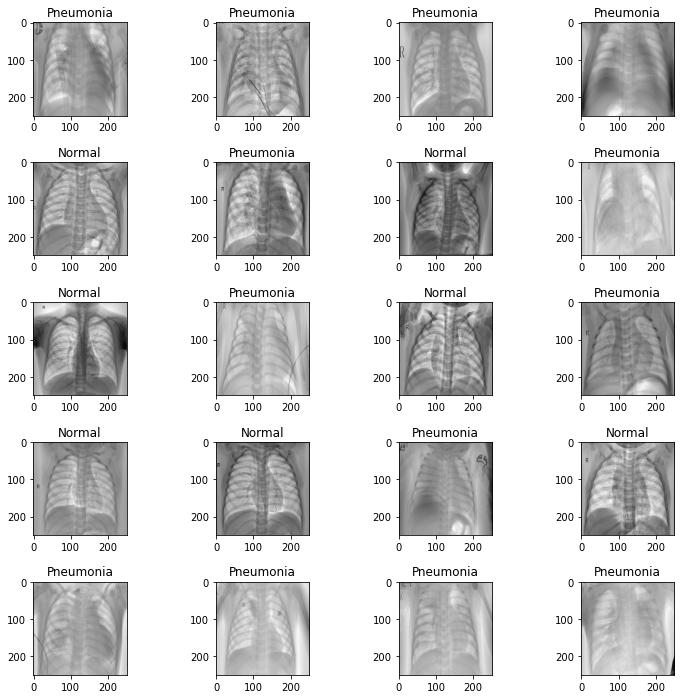

In [6]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    index = np.random.randint(len(train_images))
    img = train_images[index]
    fig.add_subplot(rows, columns, i)
    plt.title(target_names[int(train_targets[index])]) 
    plt.imshow(img.reshape(250, 250), cmap="binary")
plt.show()

# Création du modèle

## Ajout des calques

In [7]:
# Flatten
model = tf.keras.models.Sequential()

# Add the layers
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(2, activation="softmax"))

model_output = model.predict(train_images[0:1])
print(model_output, train_targets[0:1])

[[0.87010425 0.12989576]] [1.]


## Résumé du modèle utilisé

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  16000256  
_________________________________________________________________
dense_1 (Dense)              multiple                  32896     
_________________________________________________________________
dense_2 (Dense)              multiple                  258       
Total params: 16,033,410
Trainable params: 16,033,410
Non-trainable params: 0
_________________________________________________________________


## Configuration du modèle

In [9]:
# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
)

# Entrainement du modèle

In [10]:
history = model.fit(train_images,
                    train_targets,
                    epochs=20,
                    validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 2s 3ms/sample - loss: 1.1030 - accuracy: 0.8725 - val_loss: 0.3141 - val_accuracy: 0.8850
Epoch 2/20
800/800 [==============================] - 2s 2ms/sample - loss: 0.1585 - accuracy: 0.9575 - val_loss: 0.3306 - val_accuracy: 0.9050
Epoch 3/20
800/800 [==============================] - 2s 2ms/sample - loss: 0.0475 - accuracy: 0.9800 - val_loss: 0.3416 - val_accuracy: 0.8800
Epoch 4/20
800/800 [==============================] - 2s 3ms/sample - loss: 0.0313 - accuracy: 0.9912 - val_loss: 0.2078 - val_accuracy: 0.9350
Epoch 5/20
800/800 [==============================] - 2s 3ms/sample - loss: 0.0101 - accuracy: 0.9987 - val_loss: 0.2131 - val_accuracy: 0.9450
Epoch 6/20
800/800 [==============================] - 2s 2ms/sample - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.2109 - val_accuracy: 0.9450
Epoch 7/20
800/800 [==============================] - 2s 3ms/sample - loss: 0.0047 - accur

## Analyse des courbes de la fonction d'erreur et de la précision

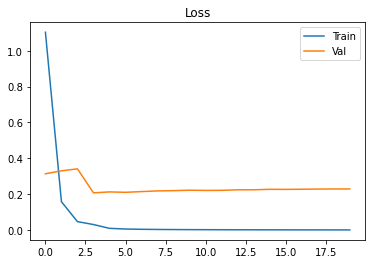

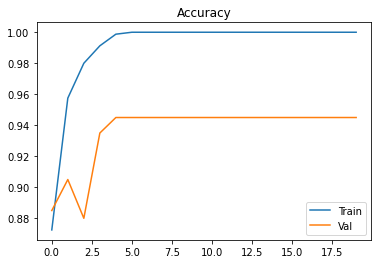

In [14]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper right')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='lower right')
plt.title("Accuracy")
plt.show()

## Évaluation du modèle sur le jeu de données de test

In [15]:
results = model.evaluate(test_images, test_targets)

print('\nTest Loss: ', results[0])
print('Test Accuracy: ', results[1])

312/312 [==============================] - 0s 910us/sample - loss: 1.0955 - accuracy: 0.8173

Test Loss:  1.0955055539424603
Test Accuracy:  0.8173077


### [H5] - Sauvegarde du modèle

In [16]:
model.save('my_model.h5')

### [H5] - Chargement du modèle

In [25]:
loaded_model = tf.keras.models.load_model("my_model.h5")
loss, acc = loaded_model.evaluate(test_images, test_targets)

312/312 [==============================] - 0s 2ms/sample - loss: 0.7910 - accuracy: 0.7981
[[8.2773754e-14 1.0000000e+00]] [1.]
Loss 0.7909523539054089
Acc 0.7980769


### [H5] - Test du modèle chargé

In [26]:
print(loaded_model.predict(test_images[0:1]), test_targets[0:1])
print("Loss", loss)
print("Acc", acc)

[[8.2773754e-14 1.0000000e+00]] [1.]
Loss 0.7909523539054089
Acc 0.7980769


### [JSON] - Sauvegarde du modèle

In [17]:
# serialize model to JSON
model_json = model.to_json()

with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_weights.h5")

Using TensorFlow backend.


### [JSON] - Chargement du modèle

In [8]:
# load json and create model
json_file = open('my_model.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")

# loaded_model.save('model_weights.hdf5')
# loaded_model=load_model('model_weights.hdf5')

Loaded model from disk


### [JSON] - Test du modèle

In [20]:
print(loaded_model.predict(test_images[0:1]), test_targets[0:1])

[[1.4815184e-07 9.9999988e-01]] [1.]
